In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import numpy as np


In [9]:
class MyMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyMLP, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
        self.decoder = nn.Sequential(
            nn.Linear(output_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return x_reconstructed  # output shape: same as input (784)


In [10]:
input_size = 784      # 28x28 images flattened
hidden_size = 128     # Size of hidden layer
output_size = 64      # Size of embedding for clustering
learning_rate = 0.001
batch_size = 64
epochs = 5

In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyMLP(input_size, hidden_size, output_size).to(device)

criterion = nn.MSELoss()   # We use MSELoss because we want to learn embeddings (unsupervised)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [13]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(data.size(0), -1).to(device)  # Flatten 28x28 to 784

        outputs = model(data)    # Get embeddings
        loss = criterion(outputs, data)   # Trying to reconstruct input (like autoencoder)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/5], Loss: 0.1027
Epoch [2/5], Loss: 0.0544
Epoch [3/5], Loss: 0.0480
Epoch [4/5], Loss: 0.0456
Epoch [5/5], Loss: 0.0449


In [14]:
model.eval()
all_embeddings = []
all_labels = []

with torch.no_grad():
    for data, targets in test_loader:
        data = data.view(data.size(0), -1).to(device)
        embeddings = model(data)
        all_embeddings.append(embeddings.cpu())
        all_labels.append(targets)

# Stack all embeddings and labels
all_embeddings = torch.cat(all_embeddings)
all_labels = torch.cat(all_labels)


In [15]:
kmeans = KMeans(n_clusters=10, random_state=42)
cluster_preds = kmeans.fit_predict(all_embeddings.numpy())


In [16]:
sil_score = silhouette_score(all_embeddings, cluster_preds)
db_index = davies_bouldin_score(all_embeddings, cluster_preds)
ch_score = calinski_harabasz_score(all_embeddings, cluster_preds)

print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin Index: {db_index:.4f}")
print(f"Calinski-Harabasz Index: {ch_score:.4f}")


Silhouette Score: 0.0837
Davies-Bouldin Index: 2.5093
Calinski-Harabasz Index: 506.7781


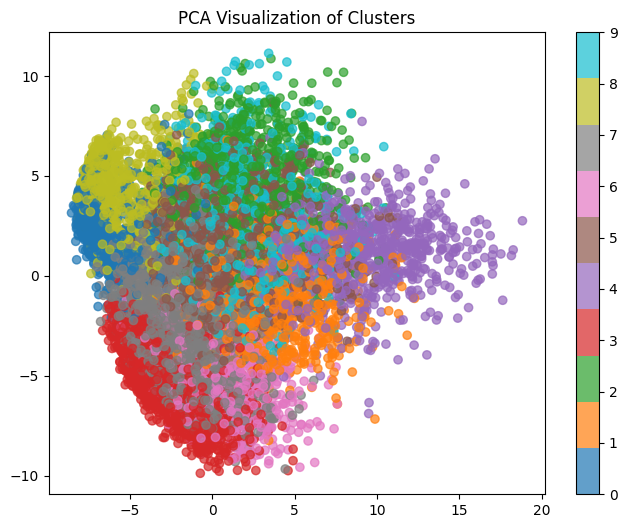

In [17]:
# Reduce dimensions for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(all_embeddings.numpy())

plt.figure(figsize=(8,6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=cluster_preds, cmap='tab10', alpha=0.7)
plt.title('PCA Visualization of Clusters')
plt.colorbar()
plt.show()
